<a href="https://colab.research.google.com/github/wajnryt/JerusMLDeepLearning2019/blob/master/LinesClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torch.utils import data
import random
import numpy as np
from collections import Counter

class ShapesDataSet(data.Dataset):
  def __init__(self, shapes, labels):
    self.shapes = shapes
    self.labels = labels
    
  def __len__(self):
    return len(self.shapes)
  
  def __getitem__(self, idx):
    return self.shapes[idx], self.labels[idx]


def createxLine() :
  mat = np.zeros((28,28),dtype="float32")
  y = np.random.randint(28)
  x = np.random.randint(20)
  size = max(3, np.random.randint(28-x))
  mat[y,x:x+size] = 1.0
  mat=mat[np.newaxis,:]
  return mat

def createyLine() :
  mat = np.zeros((28,28),dtype="float32")
  y = np.random.randint(20)
  x = np.random.randint(28)
  size = max(3,np.random.randint(28-y))
  mat[y:y+size, x] = 1.0
  mat=mat[np.newaxis,:]
  return mat

def createDiagLine() :
  mat = np.zeros((28,28),dtype="float32")
  y = np.random.randint(20)
  x = np.random.randint(20)
  size = max(3,np.random.randint(28 - max(x,y)))            
  for i in range(size) :              
    mat[y+i,x+i]=1.0
  
  mat=mat[np.newaxis,:]
  return mat
 
  
def getShape(x):
  funcs = {
  'xline': createxLine,
  'yline': createyLine,
  'diagline': createDiagLine,
  }
  return funcs[x]()
    
    

def shapesDSCreator(dssize = 10000):
  shapes = ['xline', 'yline','diagline']
  shapesDS=[]
  shapeSlabelS=[]
  
  for i in range(dssize):
    rand_shape = shapes[random.randrange(len(shapes))]
    shapesDS.append(getShape(rand_shape))
    shapeSlabelS.append(shapes.index(rand_shape))
    
  LinesDS = ShapesDataSet(shapesDS,shapeSlabelS)
    
  #Counter(shapeSlabelS)
  return LinesDS
    

In [0]:
import os
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
  os.mkdir(root)


trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
#train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
#test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

train_set = shapesDSCreator(8000)
len(train_set)
test_set = shapesDSCreator(800)
len(test_set)


batch_size = 50

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('Train size: {}'.format(len(train_loader)))




class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv3 = nn.Conv2d(50,60,3,1)
        self.fc1 = nn.Linear(240, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 240)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"
  

import time
tf = time.time()  
## training
model = LeNet()

if use_cuda:
    model = model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
predicts=[]
trainloss = []
testloss = []

for epoch in range(10):
    # trainning
    ave_loss = 0

    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)        
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))    
            
    trainloss.append(loss.data)
    
     # testing    
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x, volatile=True), Variable(target, volatile=True)
        out = model(x)        
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        predicts.append(pred_label)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss,float(correct_cnt)/total_cnt))
          
    testloss.append(loss.data)  

torch.save(model.state_dict(), model.name())

elapsed = time.time() - tf
      
    

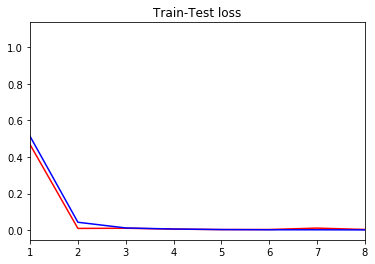

In [0]:
import matplotlib.pyplot as plt

plt.title('Train-Test loss')

plt.plot(trainloss, color='r')
plt.plot(testloss, color='b')
plt.xlim(1,8)

plt.show()


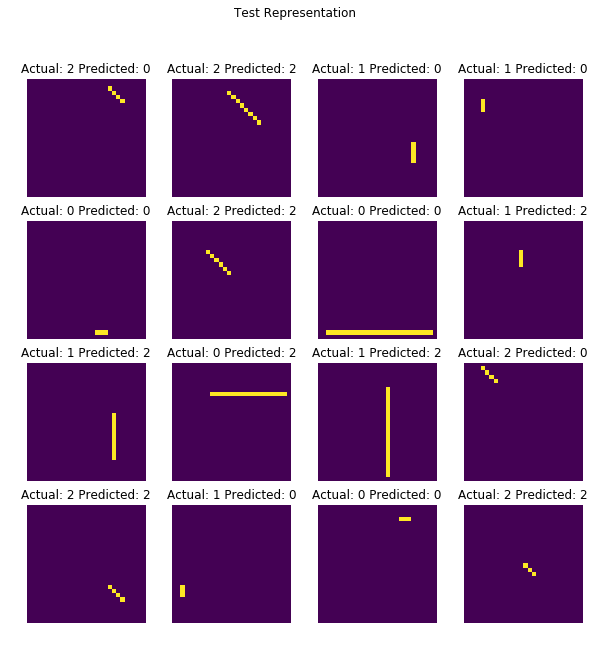

In [0]:
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt 

shapes = test_loader.dataset.shapes[:16] #[-16:]
actuals = test_loader.dataset.labels[:16]
predicted = predicts[0][:16].data.numpy()

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Test Representation')


for i in range(16):
    img = np.asarray(np.squeeze(shapes[i]))
    sub = fig.add_subplot(4, 4, i + 1)
    sub.set_title('Actual: {} Predicted: {}'.format(actuals[i],predicted[i]))
    sub.axis('off')
    sub.imshow(img, interpolation='nearest')

